In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from google.colab import drive
import time

In [ ]:
drive.mount('/content/drive')

In [3]:
CUDA=True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
gener_hidden = 64
X_DIM = 64
discrm_hidden = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [4]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.2.1+cu121


# Custom Dataset that loads images one by one

In [13]:
# Define custom dataset class
class CustomDataset1(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.hazy_dir = os.path.join(root_dir, 'hazy')
        self.gt_dir = os.path.join(root_dir, 'GT')

        # Get list of image filenames
        self.image_filenames = sorted([filename for filename in os.listdir(self.hazy_dir) if filename.endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        hazy_img_path = os.path.join(self.hazy_dir, self.image_filenames[idx])
        gt_img_path = os.path.join(self.gt_dir, self.image_filenames[idx])

        hazy_img = Image.open(hazy_img_path)
        gt_img = Image.open(gt_img_path)

        if self.transform:
            hazy_img = self.transform(hazy_img)
            gt_img = self.transform(gt_img)

        return hazy_img, gt_img

# [Efficient] Custom Dataset that loads all images when initialised

In [14]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.hazy_dir = os.path.join(root_dir, 'hazy')
        self.gt_dir = os.path.join(root_dir, 'GT')

        # Get list of image filenames
        self.image_filenames = sorted([filename for filename in os.listdir(self.hazy_dir) if filename.endswith(('.jpg', '.png'))])

        # Load all images into memory
        self.images = []
        for filename in self.image_filenames:
            hazy_img_path = os.path.join(self.hazy_dir, filename)
            gt_img_path = os.path.join(self.gt_dir, filename)
            hazy_img = Image.open(hazy_img_path)
            gt_img = Image.open(gt_img_path)
            self.images.append((hazy_img, gt_img))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        hazy_img, gt_img = self.images[idx]

        if self.transform:
            hazy_img = self.transform(hazy_img)
            gt_img = self.transform(gt_img)

        return hazy_img, gt_img


In [ ]:
# Define directories
root_dir = '/content/drive/MyDrive/Task2/Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# Define dataset transformations
transform = transforms.Compose([
    transforms.Resize(X_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_dir, transform)
val_dataset = CustomDataset(val_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [11]:
def visualise_samples(train_dataloader, num_samples = 5):
  # Visualize a few samples
  hazy_batch, gt_batch = next(iter(train_dataloader))

  num_samples = 5
  plt.figure(figsize=(15, 6))
  for i in range(num_samples):
      # Plot hazy image
      plt.subplot(2, num_samples, i + 1)
      plt.imshow(hazy_batch[i].permute(1, 2, 0))  # Permute dimensions for visualization
      plt.title("Hazy Image")
      plt.axis("off")

      # Plot ground truth image
      plt.subplot(2, num_samples, i + num_samples + 1)
      plt.imshow(gt_batch[i].permute(1, 2, 0))  # Permute dimensions for visualization
      plt.title("Ground Truth")
      plt.axis("off")

  plt.tight_layout()
  plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


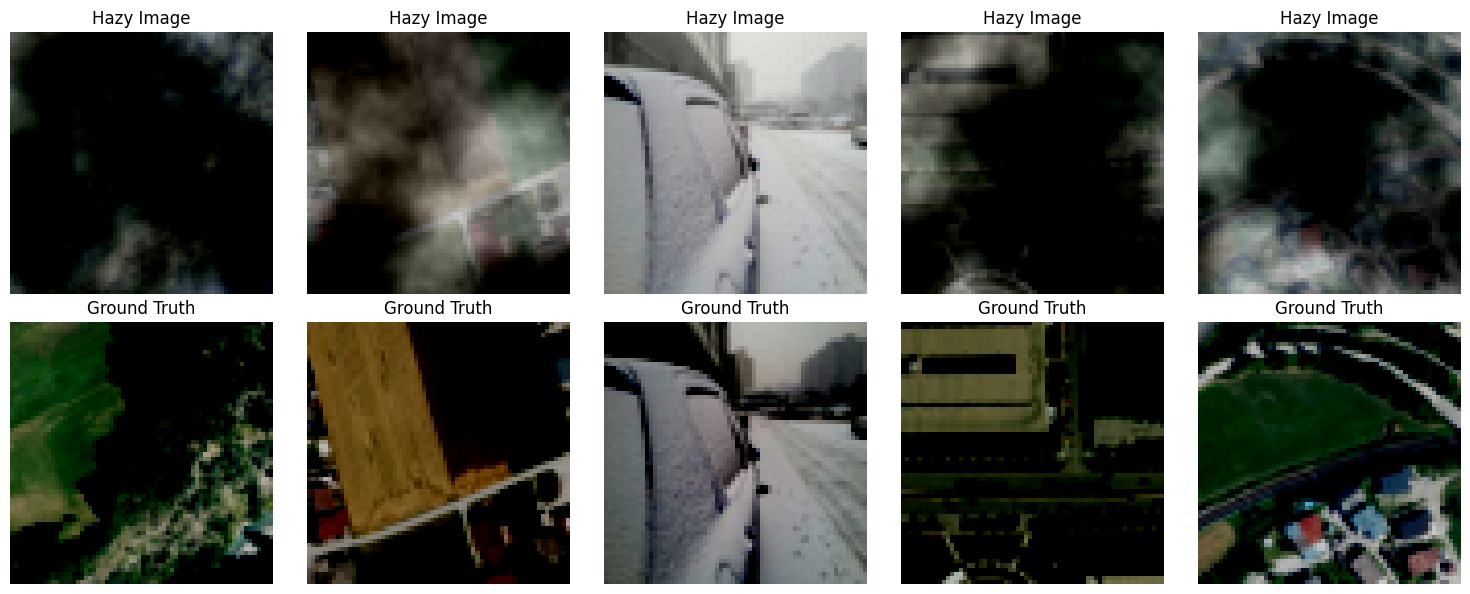

In [12]:
visualise_samples(train_dataloader, 5)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, gener_hidden * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gener_hidden * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gener_hidden * 8, gener_hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gener_hidden * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(gener_hidden * 4, gener_hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gener_hidden * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(gener_hidden * 2, gener_hidden, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gener_hidden),
            nn.ReLU(True),
            nn.ConvTranspose2d(gener_hidden, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, discrm_hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discrm_hidden, discrm_hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discrm_hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discrm_hidden * 2, discrm_hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discrm_hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discrm_hidden * 4, discrm_hidden * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discrm_hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discrm_hidden * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


start_time = time.time()
print("Starting Training Loop at time: ", start_time)


for epoch in range(EPOCH_NUM):
    for i, (hazy_images, real_images) in enumerate(train_dataloader, 0):

        hazy_images = hazy_images.to(device)
        real_images = real_images.to(device)

        # Update the discriminator
        netD.zero_grad()
        output_real = netD(real_images).view(-1)
        label_real = torch.full((real_images.size(0),), REAL_LABEL, device=device)
        errD_real = criterion(output_real, label_real)

        fake_images = netG(hazy_images)
        output_fake = netD(fake_images.detach()).view(-1)
        label_fake = torch.full((fake_images.size(0),), FAKE_LABEL, device=device)
        errD_fake = criterion(output_fake, label_fake)

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # Update the generator
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        errG = criterion(output, label_real)  # We want the fake images to be classified as real
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            elapsed_time = time.time() - start_time
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tTime: %.2f s'
                  % (epoch, EPOCH_NUM, i, len(train_dataloader),
                     errD.item(), errG.item(), elapsed_time))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4548	Loss_G: 2.0535	D(x): 0.4035	D(G(z)): 0.2597 / 0.1651
[0/5][50/469]	Loss_D: 0.0007	Loss_G: 33.8880	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.2541	Loss_G: 5.8674	D(x): 0.9477	D(G(z)): 0.1658 / 0.0065
[0/5][150/469]	Loss_D: 0.1782	Loss_G: 4.3271	D(x): 0.8957	D(G(z)): 0.0469 / 0.0208
[0/5][200/469]	Loss_D: 0.1122	Loss_G: 3.3816	D(x): 0.9404	D(G(z)): 0.0441 / 0.0509
[0/5][250/469]	Loss_D: 0.1982	Loss_G: 2.6499	D(x): 0.8673	D(G(z)): 0.0299 / 0.1093
[0/5][300/469]	Loss_D: 2.3734	Loss_G: 1.3830	D(x): 0.2202	D(G(z)): 0.0096 / 0.3156
[0/5][350/469]	Loss_D: 0.1456	Loss_G: 4.0886	D(x): 0.9702	D(G(z)): 0.1031 / 0.0239
[0/5][400/469]	Loss_D: 0.2933	Loss_G: 2.5987	D(x): 0.8748	D(G(z)): 0.1309 / 0.0984
[0/5][450/469]	Loss_D: 0.5502	Loss_G: 3.4265	D(x): 0.9061	D(G(z)): 0.2779 / 0.0683
[1/5][0/469]	Loss_D: 0.3484	Loss_G: 2.1558	D(x): 0.8392	D(G(z)): 0.1430 / 0.1486
[1/5][50/469]	Loss_D: 5.1288	Loss_G: 3.8253	D(x): 0.9997	D(G(z)):

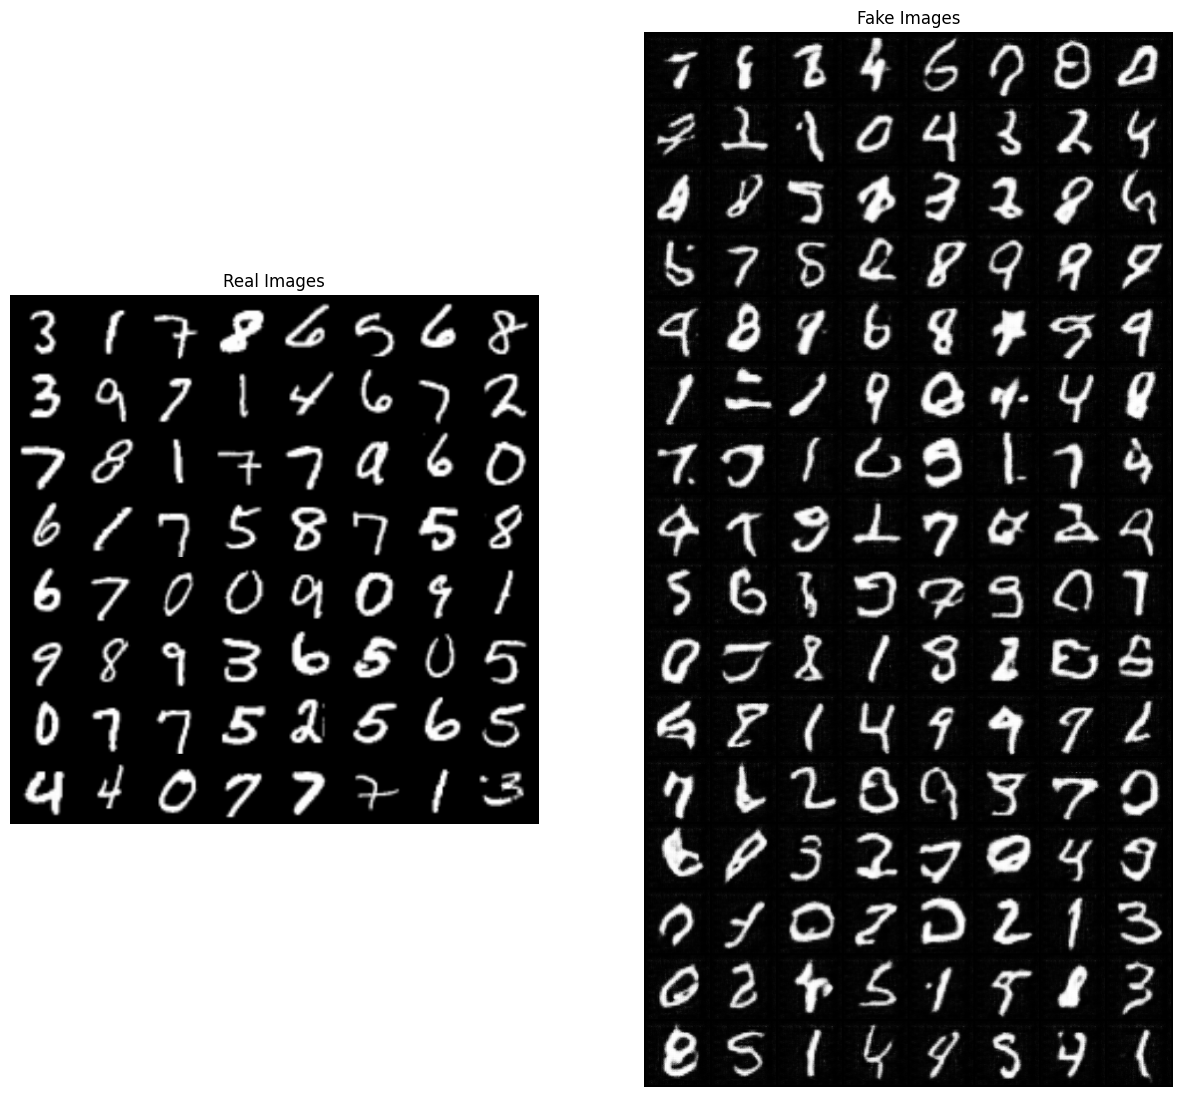

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()